In [241]:
# !pip install cvxpy
# !pip install tqdm
# !pip install yfinance
# !pip install PyPortfolioOpt

In [242]:
import numpy as np
import cvxpy as cp
import cplex
from tqdm import tqdm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf

from dateutil.relativedelta import relativedelta
from datetime import datetime

In [243]:
mkt = pd.read_csv('./new_market.csv')
mkt['pricingDate'] = pd.to_datetime(mkt['pricingDate'])
mkt.set_index('pricingDate', inplace = True)
mkt

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
pricingDate,,,,,,,,,,,,,,,,,,,,,
2018-05-01,63.574105,42.342797,40.191708,79.940979,53.921780,26.876666,140.357973,224.080000,79.992862,38.801281,...,180.343060,39.841488,58.326616,47.887170,65.827974,78.555893,108.770822,136.780000,46.462606,80.580399
2018-05-02,63.257386,41.249071,41.967178,78.609543,53.032556,26.310000,139.240061,221.100000,79.488744,38.284275,...,179.572242,39.747543,58.212919,47.839888,64.434146,72.716789,109.245154,133.120000,46.580767,77.198727
2018-05-03,63.670080,41.122121,42.043236,78.539055,53.105894,25.983333,140.182433,226.050000,79.137661,37.569084,...,180.126855,39.696300,58.015844,46.563275,65.135737,74.956321,107.124611,133.540000,45.956201,77.662499
2018-05-04,64.303518,41.854527,43.692736,78.452903,53.848442,26.276666,141.762291,228.510000,81.262162,37.793120,...,180.869471,39.619435,58.288717,47.272504,65.556692,74.738715,108.091876,134.670000,46.808649,78.802606
2018-05-07,64.677822,41.541303,44.008850,78.029977,54.380142,26.376666,140.709052,230.990000,81.469211,37.646635,...,180.399461,39.397382,58.925421,44.369392,65.500564,75.355266,108.808024,137.480000,46.850849,79.372659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,103.400002,11.040000,170.874893,145.259995,93.570000,83.489998,292.679993,521.140015,159.789993,70.612259,...,88.681633,59.470001,107.606010,31.809999,87.473717,120.309998,103.639999,198.910004,29.273745,163.279068
2023-10-26,104.309998,11.150000,166.670425,145.199997,93.980003,82.449997,292.040008,514.280029,160.860001,71.407326,...,87.285698,59.770000,106.624985,30.680000,88.400681,118.750000,103.120003,204.830002,30.083887,157.692444
2023-10-27,102.769997,10.920000,167.998672,138.929993,92.849998,81.360001,290.040008,508.119995,160.570007,69.608482,...,87.026451,58.310001,104.593567,30.600000,87.882370,119.440002,103.190002,207.179993,29.095911,155.657318


In [244]:
# S&P500 in sample
snpin = yf.download('^GSPC', '2018-05-01', '2023-04-30')['Adj Close']
snp_ret_in = snpin.pct_change().dropna()
snpin = (1 + snp_ret_in).cumprod()

[*********************100%%**********************]  1 of 1 completed


In [245]:
# S&P500 out of sample
snpout = yf.download('^GSPC', '2023-05-01', '2023-10-31')['Adj Close']
snp_ret_out = snpout.pct_change().dropna()
snpout = (1 + snp_ret_out).cumprod()

[*********************100%%**********************]  1 of 1 completed


In [246]:
# GPT 종목 (GPT weight)
stocks_15 = {
    "AAPL": 0.084, "AMZN": 0.074, "NVDA": 0.064, "JPM": 0.054, "PG": 0.054,
    "PFE": 0.064, "JNJ": 0.064, "KO": 0.054, "XOM": 0.064, "NEE": 0.074,
    "GOOGL": 0.084, "MSFT": 0.084, "TSLA": 0.074, "NKE": 0.054, "BAC": 0.054
}

stocks_30 = {
    "MSFT": 0.067, "AMZN": 0.067, "NVDA": 0.067, "AAPL": 0.067, "GOOGL": 0.067,
    "ADBE": 0.067, "JNJ": 0.05, "PFE": 0.05, "MRK": 0.05, "ABT": 0.05, 
    "PG": 0.05, "KO": 0.05, "JPM": 0.05, "GS": 0.05, "CAT": 0.025, 
    "CVX": 0.025, "XOM": 0.025, "BA": 0.025, "TSLA": 0.025, "NEE": 0.025, 
    "NKE": 0.005, "VZ": 0.005, "CRM": 0.005, "UNH": 0.005, "WMT": 0.005, 
    "QCOM": 0.005, "BAC": 0.005, "V": 0.005, "MCD": 0.005, "INTC": 0.005
}

stocks_45 = {
    "AAPL": 0.05, "GOOGL": 0.04, "MSFT": 0.04, "NVDA": 0.03, "AMD": 0.03, 
    "ORCL": 0.02, "CRM": 0.02, "INTC": 0.01, "CSCO": 0.01, "JPM": 0.04, 
    "GS": 0.03, "BAC": 0.03, "MS": 0.02, "AXP": 0.02, "C": 0.01,
    "JNJ": 0.03, "UNH": 0.03, "PFE": 0.02, "ABBV": 0.02, "TSLA": 0.02, 
    "AMGN": 0.02, "GILD": 0.01, "PG": 0.03, "KO": 0.03, "NKE": 0.02, 
    "PEP": 0.02, "COST": 0.02, "WMT": 0.02, "TGT": 0.01, "XOM": 0.025, 
    "CVX": 0.025, "NEE": 0.02, "DUK": 0.01, "SO": 0.01, "SLB": 0.01,
    "MMM": 0.02, "CAT": 0.02, "HON": 0.02, "GE": 0.02, "ADP": 0.02,
    "AMZN": 0.02, "META": 0.02, "HD": 0.02, "VZ": 0.01, "MRK": 0.01
}

In [247]:
# mkt에서 데이터 가져오는 함수
# input : 가져오고자 하는 종목의 티커, 시작 날짜, 종료 날짜

def downloads(dict, start_date, end_date):
    data = pd.DataFrame()
    a = pd.DataFrame()
    tickers = list(dict.keys())

    for ticker in tqdm(tickers):
        a = mkt.loc[start_date:end_date, ticker]
        data = pd.concat([data, a], axis=1)

    return data

In [248]:
# MDD 구하는 함수
def MDD(cumulative_returns):
    peak = cumulative_returns.iloc[0]
    drawdown = np.zeros(len(cumulative_returns))
    for i in range(1, len(cumulative_returns)):
        if cumulative_returns.iloc[i] > peak:
            peak = cumulative_returns.iloc[i]
        drawdown[i] = (peak - cumulative_returns.iloc[i]) / peak
    max_drawdown = np.max(drawdown)
    return max_drawdown

def STD(returns):
    std_dev = np.std(returns)
    return std_dev

def SHARPE(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_dev = np.std(returns)
    sharpe_ratio = mean_excess_return / std_dev if std_dev != 0 else 0
    return sharpe_ratio

## GMV + EPO

In [249]:
# GMV 함수 + shrinkage parameter

def gmv_epo(dict):

    data = downloads(dict, "2018-05-01", "2023-04-30")  # mkt 데이터에서 일별 주가데이터 가져오기
    ret = data.pct_change().dropna()
    
    num_assets = data.shape[1] # 종목 개수가 나와야함
    weights = cp.Variable((num_assets,1)) # 종목 개수랑 같아야함
    # corr_mat = np.corr(ret.values.T) # 개별 종목 별 기대수익률을 구해서 Correlation Matrix를 만듬
    corr_mat = ret.corr()

    theta = 0.75 # shrinkage parameter
    identity_matrix = np.eye(corr_mat.shape[0])  # identity matrix
    corr_mat = (1-theta) * corr_mat + theta * identity_matrix # corr_mat에 shrinkage parameter 적용

    print(corr_mat)
    
    obj = cp.Minimize(cp.quad_form(weights, corr_mat)) # 목적식 설정
    
    # 가중치 합 = 1, weights >= 0, min weight ~ max weight 범위 제약
    const = [cp.sum(weights) == 1, weights >= 0, ((1/num_assets))/2 <= weights, weights <= 2*(1/num_assets)] # 제약식 설정
    problem = cp.Problem(obj, const) # 문제 정의
    problem.solve(verbose=False, solver=cp.CPLEX) # 문제 풀기
    
    if problem.status == "optimal":
        w_opt = np.array(weights.value).flatten()
        print("Optimal")
        # print(gmv_weights.value[:5])
        
        # print(max(gmv_weights.value)) # 가장 큰 weight를 보고싶으면 이거 주석 해제
    else:
        print("It isn't optimal")

    return w_opt

In [250]:
gmv_epo_15 = gmv_epo(stocks_15)
gmv_epo_30 = gmv_epo(stocks_30)
gmv_epo_45 = gmv_epo(stocks_45)

100%|██████████| 15/15 [00:00<00:00, 326.01it/s]

           AAPL      AMZN      NVDA       JPM        PG       PFE       JNJ  \
AAPL   1.000000  0.162753  0.165199  0.115250  0.106273  0.085967  0.102259   
AMZN   0.162753  1.000000  0.158863  0.077786  0.067204  0.059446  0.065121   
NVDA   0.165199  0.158863  1.000000  0.096101  0.072584  0.061418  0.064262   
JPM    0.115250  0.077786  0.096101  1.000000  0.096757  0.094424  0.103706   
PG     0.106273  0.067204  0.072584  0.096757  1.000000  0.110150  0.149072   
PFE    0.085967  0.059446  0.061418  0.094424  0.110150  1.000000  0.137005   
JNJ    0.102259  0.065121  0.064262  0.103706  0.149072  0.137005  1.000000   
KO     0.104784  0.060730  0.067774  0.133831  0.160772  0.110861  0.139633   
XOM    0.084547  0.052404  0.069364  0.149521  0.060646  0.073075  0.080932   
NEE    0.107161  0.077029  0.085984  0.093084  0.142384  0.090487  0.116875   
GOOGL  0.173516  0.171445  0.162048  0.115306  0.093502  0.081097  0.092319   
MSFT   0.190868  0.178616  0.176703  0.116581  0.117

Optimal


100%|██████████| 30/30 [00:00<00:00, 379.66it/s]

           MSFT      AMZN      NVDA      AAPL     GOOGL      ADBE       JNJ  \
MSFT   1.000000  0.178616  0.176703  0.190868  0.198436  0.199163  0.109599   
AMZN   0.178616  1.000000  0.158863  0.162753  0.171445  0.168519  0.065121   
NVDA   0.176703  0.158863  1.000000  0.165199  0.162048  0.169214  0.064262   
AAPL   0.190868  0.162753  0.165199  1.000000  0.173516  0.170284  0.102259   
GOOGL  0.198436  0.171445  0.162048  0.173516  1.000000  0.177272  0.092319   
ADBE   0.199163  0.168519  0.169214  0.170284  0.177272  1.000000  0.081483   
JNJ    0.109599  0.065121  0.064262  0.102259  0.092319  0.081483  1.000000   
PFE    0.093880  0.059446  0.061418  0.085967  0.081097  0.072437  0.137005   
MRK    0.097547  0.050738  0.054980  0.085134  0.077792  0.075828  0.145159   
ABT    0.152756  0.109793  0.120304  0.136575  0.130005  0.135331  0.143535   
PG     0.117609  0.067204  0.072584  0.106273  0.093502  0.089905  0.149072   
KO     0.112043  0.060730  0.067774  0.104784  0.099

Optimal


100%|██████████| 45/45 [00:00<00:00, 384.53it/s]

           AAPL     GOOGL      MSFT      NVDA       AMD      ORCL       CRM  \
AAPL   1.000000  0.173516  0.190868  0.165199  0.141274  0.131698  0.147574   
GOOGL  0.173516  1.000000  0.198436  0.162048  0.135988  0.122900  0.154663   
MSFT   0.190868  0.198436  1.000000  0.176703  0.145965  0.147717  0.174999   
NVDA   0.165199  0.162048  0.176703  1.000000  0.182671  0.114166  0.152039   
AMD    0.141274  0.135988  0.145965  0.182671  1.000000  0.100725  0.128619   
ORCL   0.131698  0.122900  0.147717  0.114166  0.100725  1.000000  0.118843   
CRM    0.147574  0.154663  0.174999  0.152039  0.128619  0.118843  1.000000   
INTC   0.147433  0.142611  0.156226  0.149574  0.119337  0.121171  0.116362   
CSCO   0.149433  0.138201  0.156082  0.125714  0.110769  0.145417  0.120627   
JPM    0.115250  0.115306  0.116581  0.096101  0.079671  0.128763  0.092886   
GS     0.130869  0.129514  0.130563  0.115477  0.096580  0.127803  0.107373   
BAC    0.115960  0.117566  0.117973  0.099099  0.085

Optimal


In [251]:
print('GMV EPO 15 weights')
print(list(gmv_epo_15))

print('GMV EPO 30 weights')
print(list(gmv_epo_30))

print('GMV EPO 45 weights')
print(list(gmv_epo_45))

GMV EPO 15 weights
[0.04586592679932031, 0.07290333429893997, 0.0650048313996372, 0.05601477729657689, 0.07202206463523077, 0.08696588547725714, 0.07263891622394651, 0.06223162148560778, 0.08611517026411146, 0.07257212522916007, 0.05026269891875089, 0.03845480136290276, 0.10063796577462439, 0.06150024343547563, 0.05680963739845821]
GMV EPO 30 weights
[0.01666666771539571, 0.04249036171380837, 0.03132452088093352, 0.01666667170178015, 0.018251729717538464, 0.02575978687029182, 0.0352316926496697, 0.051941993397833314, 0.04739950100042145, 0.022780535177473464, 0.03628957370295108, 0.026729967404865333, 0.01930100935591261, 0.01782646425127172, 0.0338665500642196, 0.03458314910036923, 0.04473207573655366, 0.040269441125665564, 0.06666666281593624, 0.03861618729109159, 0.028653180105589916, 0.05247904370962589, 0.03519214728871102, 0.028715150264019856, 0.05728694989644465, 0.036807818377809054, 0.020312146885578267, 0.01666666801951505, 0.028938651412171234, 0.027553702366552413]
GMV EPO

In [252]:
# 동일 가중
def make_dict(dict):
    dic = {}
    
    for column in dict.keys():
        dic[column] = 1/len(dict.keys())

    return dic
    
gpt15_same = make_dict(stocks_15)
gpt30_same = make_dict(stocks_30)
gpt45_same = make_dict(stocks_45)

In [253]:
# 누적 수익률 함수
# bool에 True를 넣으면 gpt gmv epo opt 데이터로 실행, False이면 GPT로 이미 가져와있는거 실행

# MDD 구하는 함수
def MDD(cumulative_returns):
    peak = cumulative_returns.iloc[0]
    drawdown = np.zeros(len(cumulative_returns))
    for i in range(1, len(cumulative_returns)):
        if cumulative_returns.iloc[i] > peak:
            peak = cumulative_returns.iloc[i]
        drawdown[i] = (peak - cumulative_returns.iloc[i]) / peak
    max_drawdown = np.max(drawdown)
    return max_drawdown

def STD(returns):
    std_dev = np.std(returns)
    return std_dev

def SHARPE(returns, risk_free_rate=0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_dev = np.std(returns)
    sharpe_ratio = mean_excess_return / std_dev if std_dev != 0 else 0
    return sharpe_ratio

def cum_ret_gmv_epo(dic, w_opt, start_date, end_date):  
    
    result = dict(zip(list(dic.keys()), w_opt))
    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()
    print(f'포트폴리오의 MDD는: {round(MDD(cum_ret),2)*100}%')
    print(f'포트폴리오의 표준편차는: {round(STD(pfo_ret),4)}')
    
    r_f = 0.02
    print(f'포트폴리오의 Sharpe Ratio는: {round(SHARPE(pfo_ret, r_f),2)}')

    return cum_ret

def cum_ret_gpt(dic, start_date, end_date):  

    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(dic))
    cum_ret = (1 + pfo_ret).cumprod()        
        
    return cum_ret

In [254]:
gmv_epo_15

array([0.04586593, 0.07290333, 0.06500483, 0.05601478, 0.07202206,
       0.08696589, 0.07263892, 0.06223162, 0.08611517, 0.07257213,
       0.0502627 , 0.0384548 , 0.10063797, 0.06150024, 0.05680964])

### in-sample 누적 수익률 확인 2018-05-01 ~ 2023-04-30

In [255]:
# gmv+epo
cum_15 = cum_ret_gmv_epo(stocks_15, gmv_epo_15, '2018-05-01', '2023-04-30')
cum_30 = cum_ret_gmv_epo(stocks_30, gmv_epo_30, '2018-05-01', '2023-04-30')
cum_45 = cum_ret_gmv_epo(stocks_45, gmv_epo_45, '2018-05-01', '2023-04-30')

# equal weight
cum_eq_15 = cum_ret_gpt(gpt15_same, '2018-05-01', '2023-04-30')
cum_eq_30 = cum_ret_gpt(gpt30_same, '2018-05-01', '2023-04-30')
cum_eq_45 = cum_ret_gpt(gpt45_same, '2018-05-01', '2023-04-30')

# gpt weight
gpt_15_in = cum_ret_gpt(stocks_15, '2018-05-01', '2023-04-30')
gpt_30_in = cum_ret_gpt(stocks_30, '2018-05-01', '2023-04-30')
gpt_45_in = cum_ret_gpt(stocks_45, '2018-05-01', '2023-04-30')

100%|██████████| 15/15 [00:00<00:00, 356.45it/s]


포트폴리오의 MDD는: 34.0%
포트폴리오의 표준편차는: 0.0144
포트폴리오의 Sharpe Ratio는: -1.33


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 328.04it/s]


포트폴리오의 MDD는: 32.0%
포트폴리오의 표준편차는: 0.0135
포트폴리오의 Sharpe Ratio는: -1.42


100%|██████████| 45/45 [00:00<00:00, 399.96it/s]


포트폴리오의 MDD는: 31.0%
포트폴리오의 표준편차는: 0.0131
포트폴리오의 Sharpe Ratio는: -1.46


100%|██████████| 45/45 [00:00<00:00, 401.44it/s]


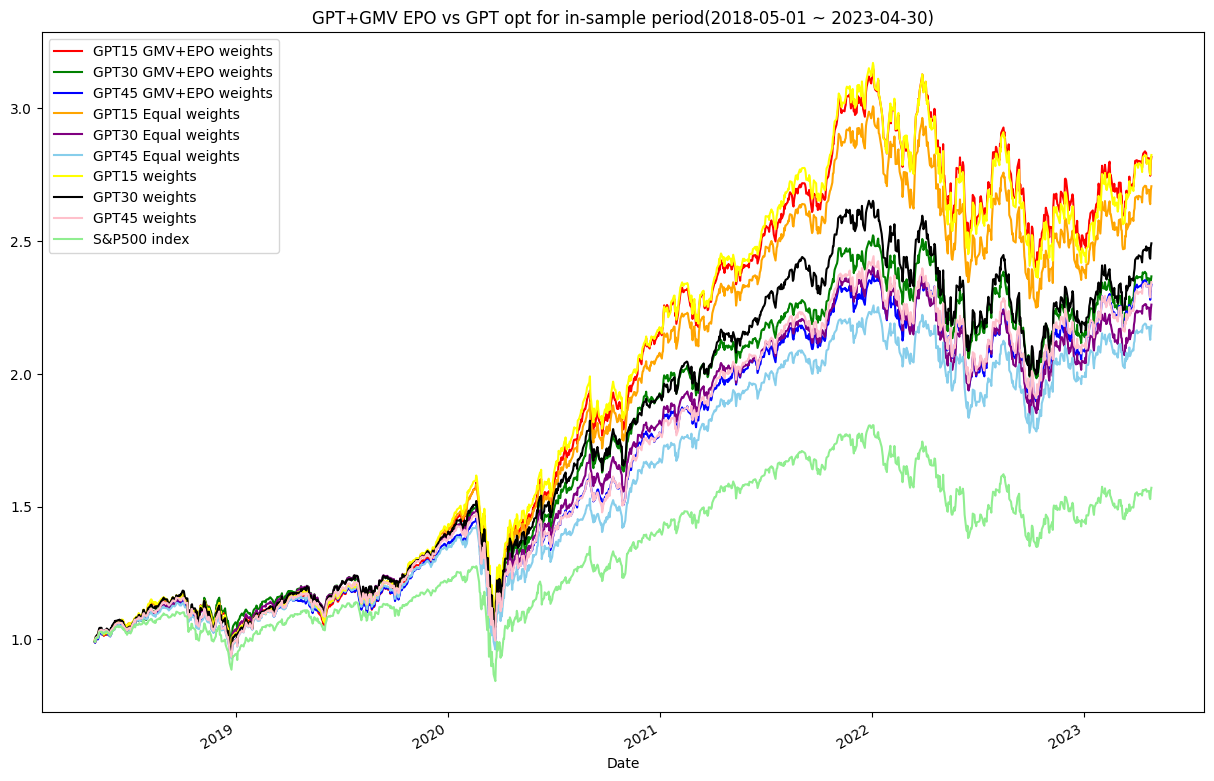

In [256]:
# Log return

plt.figure(figsize=(15,10))
plt.title("GPT+GMV EPO vs GPT opt for in-sample period(2018-05-01 ~ 2023-04-30)")

cum_15.plot(label='GPT15 GMV+EPO weights', color='red')
cum_30.plot(label='GPT30 GMV+EPO weights', color='green')
cum_45.plot(label='GPT45 GMV+EPO weights', color='blue')
cum_eq_15.plot(label='GPT15 Equal weights', color='orange')
cum_eq_30.plot(label='GPT30 Equal weights', color='purple')
cum_eq_45.plot(label='GPT45 Equal weights', color='skyblue')
gpt_15_in.plot(label='GPT15 weights', color='yellow')
gpt_30_in.plot(label='GPT30 weights', color='black')
gpt_45_in.plot(label='GPT45 weights', color='pink')
snpin.plot(label='S&P500 index', color='lightgreen')

plt.legend()
plt.show()

In [257]:
print(cum_15.iloc[-1])  # 마지막 시점의 cum_15 값
print(cum_30.iloc[-1])  # 마지막 시점의 cum_30 값
print(cum_45.iloc[-1])  # 마지막 시점의 cum_45 값

print('-----------------------------------------')

print(cum_eq_15.iloc[-1])  # 마지막 시점의 cum_eq_15 값
print(cum_eq_30.iloc[-1])  # 마지막 시점의 cum_eq_30 값
print(cum_eq_45.iloc[-1])  # 마지막 시점의 cum_eq_45 값

print('-----------------------------------------')

print(gpt_15_in.iloc[-1])  # 마지막 시점의 gpt_15_in 값
print(gpt_30_in.iloc[-1])  # 마지막 시점의 gpt_30_in 값
print(gpt_45_in.iloc[-1])  # 마지막 시점의 gpt_45_in 값

print('-----------------------------------------')

print(snpin.iloc[-1])  # 마지막 시점의 snpin 값

2.816074264038082
2.36665804332862
2.335386279238515
-----------------------------------------
2.7061165235927196
2.260197455667387
2.181111816519948
-----------------------------------------
2.8237216659485793
2.4910817485574697
2.345144871791912
-----------------------------------------
1.570543884202969


### out-of-sample 누적 수익률 확인 2023-05-01 ~ 2023-10-10

In [258]:
# gmv+epo
cum_15 = cum_ret_gmv_epo(stocks_15, gmv_epo_15, '2023-05-01', '2023-10-31')
cum_30 = cum_ret_gmv_epo(stocks_30, gmv_epo_30, '2023-05-01', '2023-10-31')
cum_45 = cum_ret_gmv_epo(stocks_45, gmv_epo_45, '2023-05-01', '2023-10-31')

# equal weight
cum_eq_15 = cum_ret_gpt(gpt15_same, '2023-05-01', '2023-10-31')
cum_eq_30 = cum_ret_gpt(gpt30_same, '2023-05-01', '2023-10-31')
cum_eq_45 = cum_ret_gpt(gpt45_same, '2023-05-01', '2023-10-31')

# gpt weight
gpt_15_out = cum_ret_gpt(stocks_15, '2023-04-29', '2023-10-31')
gpt_30_out = cum_ret_gpt(stocks_30, '2023-04-29', '2023-10-31')
gpt_45_out = cum_ret_gpt(stocks_45, '2023-04-29', '2023-10-31')

100%|██████████| 15/15 [00:00<00:00, 711.54it/s]


포트폴리오의 MDD는: 12.0%
포트폴리오의 표준편차는: 0.0081
포트폴리오의 Sharpe Ratio는: -2.46


100%|██████████| 30/30 [00:00<00:00, 785.65it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0072
포트폴리오의 Sharpe Ratio는: -2.75


100%|██████████| 45/45 [00:00<00:00, 772.95it/s]


포트폴리오의 MDD는: 9.0%
포트폴리오의 표준편차는: 0.0071
포트폴리오의 Sharpe Ratio는: -2.81


100%|██████████| 45/45 [00:00<00:00, 785.93it/s]


In [259]:
gpt_15_out = cum_ret_gpt(stocks_15, '2023-04-29', '2023-10-31')
gpt_30_out = cum_ret_gpt(stocks_30, '2023-04-29', '2023-10-31')
gpt_45_out = cum_ret_gpt(stocks_45, '2023-04-29', '2023-10-31')

100%|██████████| 15/15 [00:00<00:00, 679.03it/s]


100%|██████████| 45/45 [00:00<00:00, 772.39it/s]


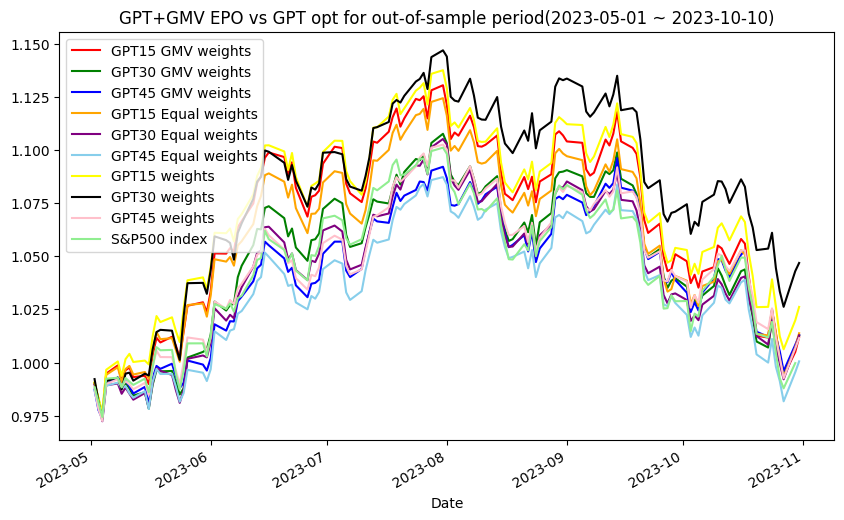

In [260]:
# Log

plt.figure(figsize=(10,6))
plt.title("GPT+GMV EPO vs GPT opt for out-of-sample period(2023-05-01 ~ 2023-10-10)")

cum_15.plot(label='GPT15 GMV weights', color='red')
cum_30.plot(label='GPT30 GMV weights', color='green')
cum_45.plot(label='GPT45 GMV weights', color='blue')
cum_eq_15.plot(label='GPT15 Equal weights', color='orange')
cum_eq_30.plot(label='GPT30 Equal weights', color='purple')
cum_eq_45.plot(label='GPT45 Equal weights', color='skyblue')
gpt_15_out.plot(label='GPT15 weights', color='yellow')
gpt_30_out.plot(label='GPT30 weights', color='black')
gpt_45_out.plot(label='GPT45 weights', color='pink')
snpout.plot(label='S&P500 index', color='lightgreen')

plt.legend()
plt.show()

In [261]:
print(cum_15.iloc[-1])  # 마지막 시점의 cum_15 값
print(cum_30.iloc[-1])  # 마지막 시점의 cum_30 값
print(cum_45.iloc[-1])  # 마지막 시점의 cum_45 값

print('-----------------------------------------')

print(cum_eq_15.iloc[-1])  # 마지막 시점의 cum_eq_15 값
print(cum_eq_30.iloc[-1])  # 마지막 시점의 cum_eq_30 값
print(cum_eq_45.iloc[-1])  # 마지막 시점의 cum_eq_45 값

print('-----------------------------------------')

print(gpt_15_out.iloc[-1])  # 마지막 시점의 gpt_15_out 값
print(gpt_30_out.iloc[-1])  # 마지막 시점의 gpt_30_out 값
print(gpt_45_out.iloc[-1])  # 마지막 시점의 gpt_45_out 값

print('-----------------------------------------')

print(snpout.iloc[-1])  # 마지막 시점의 snpout 값

1.0119288867412812
1.0126764918314783
1.012789832494831
-----------------------------------------
1.0137846445574363
1.0128294199046595
1.0005676210191787
-----------------------------------------
1.0261699613903503
1.0468227153541398
1.011530650327948
-----------------------------------------
0.9997480024714747


## Max Sharpe + EPO

In [262]:
# Max Sharpe 함수 + shrinkage parameter
def max_sharpe_epo(dict):
    df = downloads(dict, "2018-05-01", "2023-04-30")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    stds = np.sqrt(np.diag(S)) # cov의 표준편차
    S = risk_models.cov_to_corr(S) # cov -> corr
    theta = 0.75 # shrinkage parameter
    identity_matrix = np.eye(S.shape[0])  # identity matrix
    S = (1-theta)* S + theta * identity_matrix # shrinkage 반영된 correlation matrix
    S = risk_models.corr_to_cov(S, stds)
    ef = EfficientFrontier(mu, S)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets

    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)
    
    ef.add_constraint(lambda w: w.sum() == 1)

    w_opt = ef.max_sharpe() # Max Sharpe ratio가 되는 weights 찾기
    # print('w_opt:', w_opt)
    w_clean = ef.clean_weights()
    # print('w_clean',w_clean.values())
    ef.portfolio_performance(verbose=True)

    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean  #.values()

In [263]:
msp_epo_15 = max_sharpe_epo(stocks_15)
msp_epo_30 = max_sharpe_epo(stocks_30)
msp_epo_45 = max_sharpe_epo(stocks_45)

100%|██████████| 15/15 [00:00<00:00, 348.13it/s]


Expected annual return: 22.9%
Annual volatility: 14.8%
Sharpe Ratio: 1.42

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████| 30/30 [00:00<00:00, 398.96it/s]

Expected annual return: 19.4%


Annual volatility: 12.7%
Sharpe Ratio: 1.38

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████| 45/45 [00:00<00:00, 396.33it/s]


Expected annual return: 19.3%
Annual volatility: 11.9%
Sharpe Ratio: 1.45

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [264]:
print('MAX sharpe EPO 15 tickers')
print(list(msp_epo_15))

print('MAX sharpe EPO 30 tickers')
print(list(msp_epo_30))

print('MAX sharpe EPO 45 tickers')
print(list(msp_epo_45))

MAX sharpe EPO 15 tickers
['AAPL', 'AMZN', 'NVDA', 'JPM', 'PG', 'PFE', 'JNJ', 'KO', 'XOM', 'NEE', 'GOOGL', 'MSFT', 'TSLA', 'NKE', 'BAC']
MAX sharpe EPO 30 tickers
['MSFT', 'AMZN', 'NVDA', 'AAPL', 'GOOGL', 'ADBE', 'JNJ', 'PFE', 'MRK', 'ABT', 'PG', 'KO', 'JPM', 'GS', 'CAT', 'CVX', 'XOM', 'BA', 'TSLA', 'NEE', 'NKE', 'VZ', 'CRM', 'UNH', 'WMT', 'QCOM', 'BAC', 'V', 'MCD', 'INTC']
MAX sharpe EPO 45 tickers
['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMD', 'ORCL', 'CRM', 'INTC', 'CSCO', 'JPM', 'GS', 'BAC', 'MS', 'AXP', 'C', 'JNJ', 'UNH', 'PFE', 'ABBV', 'TSLA', 'AMGN', 'GILD', 'PG', 'KO', 'NKE', 'PEP', 'COST', 'WMT', 'TGT', 'XOM', 'CVX', 'NEE', 'DUK', 'SO', 'SLB', 'MMM', 'CAT', 'HON', 'GE', 'ADP', 'AMZN', 'META', 'HD', 'VZ', 'MRK']


In [265]:
msp_epo_15_w = max_sharpe_epo(stocks_15).values()
msp_epo_30_w = max_sharpe_epo(stocks_30).values()
msp_epo_45_w = max_sharpe_epo(stocks_45).values()

100%|██████████| 15/15 [00:00<00:00, 319.08it/s]

Expected annual return: 22.9%
Annual volatility: 14.8%
Sharpe Ratio: 1.42

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████| 30/30 [00:00<00:00, 399.20it/s]

Expected annual return: 19.4%
Annual volatility: 12.7%
Sharpe Ratio: 1.38

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667



100%|██████████| 45/45 [00:00<00:00, 396.31it/s]


Expected annual return: 19.3%
Annual volatility: 11.9%
Sharpe Ratio: 1.45

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [266]:
print('MAX sharpe EPO 15 weights')
print(list(msp_epo_15_w))

print('MAX sharpe EPO 30 weights')
print(list(msp_epo_30_w))

print('MAX sharpe EPO 45 weights')
print(list(msp_epo_45_w))

MAX sharpe EPO 15 weights
[0.13333, 0.03333, 0.06788, 0.03333, 0.13333, 0.03333, 0.03333, 0.08496, 0.04447, 0.08522, 0.03333, 0.13333, 0.08414, 0.03333, 0.03333]
MAX sharpe EPO 30 weights
[0.06667, 0.01667, 0.05421, 0.06667, 0.01667, 0.01667, 0.01667, 0.01667, 0.06667, 0.03041, 0.06667, 0.04057, 0.01667, 0.01667, 0.01667, 0.01667, 0.0196, 0.01667, 0.06667, 0.05565, 0.01667, 0.01667, 0.01667, 0.04819, 0.06667, 0.01804, 0.01667, 0.01667, 0.06667, 0.01667]
MAX sharpe EPO 45 weights
[0.04444, 0.01111, 0.04444, 0.04208, 0.04444, 0.03115, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.03427, 0.01111, 0.03202, 0.04444, 0.01111, 0.01111, 0.04444, 0.02286, 0.01111, 0.04444, 0.04444, 0.04444, 0.04444, 0.01111, 0.01111, 0.04003, 0.01111, 0.04203, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.04444]


In [267]:
# 누적 수익률 함수
def max_sharpe_epo_cum_ret(dic, result, start_date, end_date):
    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    print(f'포트폴리오의 MDD는: {round(MDD(cum_ret),2)*100}%')
    print(f'포트폴리오의 표준편차는: {round(STD(pfo_ret),4)}')
    
    r_f = 0.02
    print(f'포트폴리오의 Sharpe Ratio는: {round(SHARPE(pfo_ret, r_f),2)}')

    return cum_ret

### in-sample 누적 수익률 확인 2018-05-01 ~ 2023-04-30

In [268]:
# max sharpe + epo
msf_15 = max_sharpe_epo_cum_ret(stocks_15, msp_epo_15, '2018-05-01', '2023-04-30')
msf_30 = max_sharpe_epo_cum_ret(stocks_30, msp_epo_30, '2018-05-01', '2023-04-30')
msf_45 = max_sharpe_epo_cum_ret(stocks_45, msp_epo_45, '2018-05-01', '2023-04-30')

# equal weight
cum_eq_15 = cum_ret_gpt(gpt15_same, '2018-05-01', '2023-04-30')
cum_eq_30 = cum_ret_gpt(gpt30_same, '2018-05-01', '2023-04-30')
cum_eq_45 = cum_ret_gpt(gpt45_same, '2018-05-01', '2023-04-30')

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 348.20it/s]


포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.0147
포트폴리오의 Sharpe Ratio는: -1.29


100%|██████████| 30/30 [00:00<00:00, 404.08it/s]


포트폴리오의 MDD는: 31.0%
포트폴리오의 표준편차는: 0.0136
포트폴리오의 Sharpe Ratio는: -1.4


100%|██████████| 45/45 [00:00<00:00, 386.17it/s]


포트폴리오의 MDD는: 30.0%
포트폴리오의 표준편차는: 0.0133
포트폴리오의 Sharpe Ratio는: -1.43


100%|██████████| 45/45 [00:00<00:00, 407.29it/s]


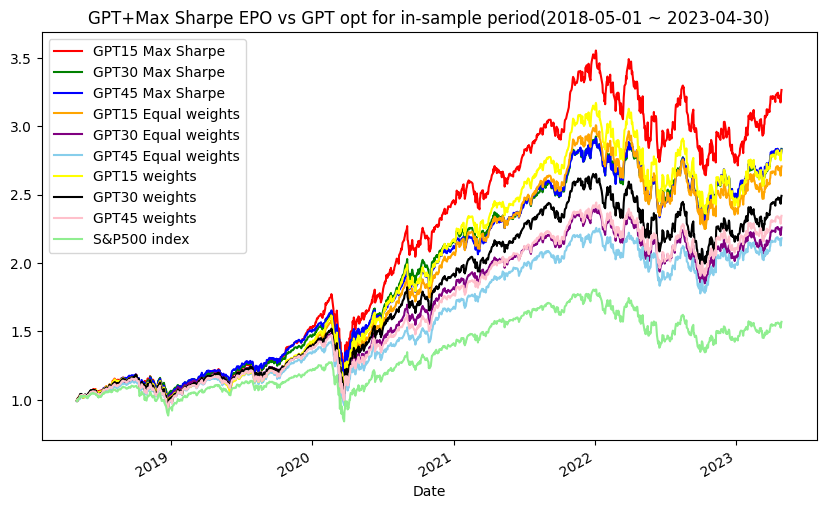

In [269]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Sharpe EPO vs GPT opt for in-sample period(2018-05-01 ~ 2023-04-30)")

msf_15.plot(label='GPT15 Max Sharpe', color='red')
msf_30.plot(label='GPT30 Max Sharpe', color='green')
msf_45.plot(label='GPT45 Max Sharpe', color='blue')
cum_eq_15.plot(label='GPT15 Equal weights', color='orange')
cum_eq_30.plot(label='GPT30 Equal weights', color='purple')
cum_eq_45.plot(label='GPT45 Equal weights', color='skyblue')
gpt_15_in.plot(label='GPT15 weights', color='yellow')
gpt_30_in.plot(label='GPT30 weights', color='black')
gpt_45_in.plot(label='GPT45 weights', color='pink')
snpin.plot(label='S&P500 index', color='lightgreen')

plt.legend()
plt.show()

In [270]:
print(msf_15.iloc[-1])  # 마지막 시점의 msf_15 값
print(msf_30.iloc[-1])  # 마지막 시점의 msf_30 값
print(msf_45.iloc[-1])  # 마지막 시점의 msf_45 값

print('-----------------------------------------')

print(cum_eq_15.iloc[-1])  # 마지막 시점의 cum_eq_15 값
print(cum_eq_30.iloc[-1])  # 마지막 시점의 cum_eq_30 값
print(cum_eq_45.iloc[-1])  # 마지막 시점의 cum_eq_45 값

print('-----------------------------------------')

print(gpt_15_in.iloc[-1])  # 마지막 시점의 gpt_15_in 값
print(gpt_30_in.iloc[-1])  # 마지막 시점의 gpt_30_in 값
print(gpt_45_in.iloc[-1])  # 마지막 시점의 gpt_45_in 값

print('-----------------------------------------')

print(snpin.iloc[-1])  # 마지막 시점의 snpin 값

3.2645284110479302
2.8341748753921667
2.8297040912535527
-----------------------------------------
2.7061165235927196
2.260197455667387
2.181111816519948
-----------------------------------------
2.8237216659485793
2.4910817485574697
2.345144871791912
-----------------------------------------
1.570543884202969


### out-of-sample 누적 수익률 확인 2023-05-01 ~ 2023-10-10

In [271]:
#  max sharpe + epo
msf_15 = max_sharpe_epo_cum_ret(stocks_15, msp_epo_15, '2023-04-29', '2023-10-31')
msf_30 = max_sharpe_epo_cum_ret(stocks_30, msp_epo_30, '2023-04-29', '2023-10-31')
msf_45 = max_sharpe_epo_cum_ret(stocks_45, msp_epo_45, '2023-04-29', '2023-10-31')

# equal weight
cum_eq_15 = cum_ret_gpt(gpt15_same, '2023-05-01', '2023-10-31')
cum_eq_30 = cum_ret_gpt(gpt30_same, '2023-05-01', '2023-10-31')
cum_eq_45 = cum_ret_gpt(gpt45_same, '2023-05-01', '2023-10-31')

100%|██████████| 15/15 [00:00<00:00, 711.86it/s]


포트폴리오의 MDD는: 11.0%
포트폴리오의 표준편차는: 0.0083
포트폴리오의 Sharpe Ratio는: -2.39


100%|██████████| 30/30 [00:00<00:00, 785.77it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0071
포트폴리오의 Sharpe Ratio는: -2.79


100%|██████████| 45/45 [00:00<00:00, 772.48it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0071
포트폴리오의 Sharpe Ratio는: -2.82


100%|██████████| 45/45 [00:00<00:00, 799.32it/s]


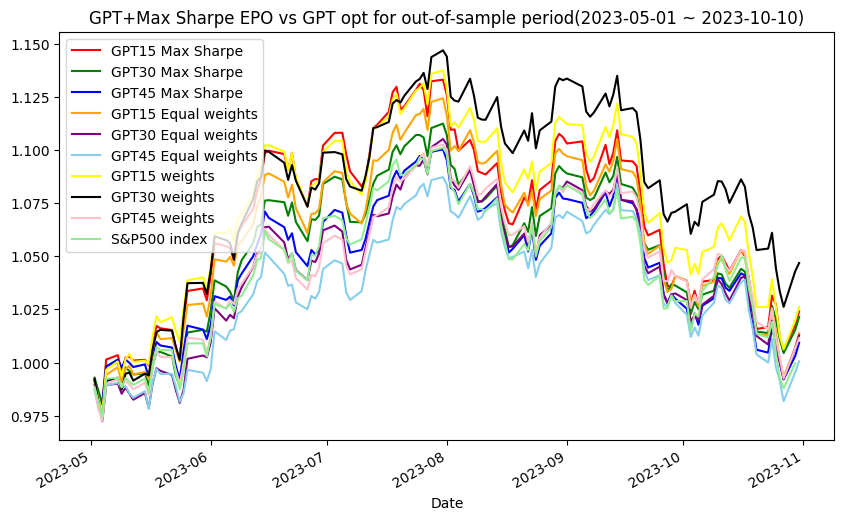

In [272]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Sharpe EPO vs GPT opt for out-of-sample period(2023-05-01 ~ 2023-10-10)")

msf_15.plot(label='GPT15 Max Sharpe', color='red')
msf_30.plot(label='GPT30 Max Sharpe', color='green')
msf_45.plot(label='GPT45 Max Sharpe', color='blue')
cum_eq_15.plot(label='GPT15 Equal weights', color='orange')
cum_eq_30.plot(label='GPT30 Equal weights', color='purple')
cum_eq_45.plot(label='GPT45 Equal weights', color='skyblue')
gpt_15_out.plot(label='GPT15 weights', color='yellow')
gpt_30_out.plot(label='GPT30 weights', color='black')
gpt_45_out.plot(label='GPT45 weights', color='pink')
snpout.plot(label='S&P500 index', color='lightgreen')

plt.legend()
plt.show()

In [273]:
print(msf_15.iloc[-1])  # 마지막 시점의 msf_15 값
print(msf_30.iloc[-1])  # 마지막 시점의 msf_30 값
print(msf_45.iloc[-1])  # 마지막 시점의 msf_45 값

print('-----------------------------------------')

print(cum_eq_15.iloc[-1])  # 마지막 시점의 cum_eq_15 값
print(cum_eq_30.iloc[-1])  # 마지막 시점의 cum_eq_30 값
print(cum_eq_45.iloc[-1])  # 마지막 시점의 cum_eq_45 값

print('-----------------------------------------')

print(gpt_15_out.iloc[-1])  # 마지막 시점의 gpt_15_out 값
print(gpt_30_out.iloc[-1])  # 마지막 시점의 gpt_30_out 값
print(gpt_45_out.iloc[-1])  # 마지막 시점의 gpt_45_out 값

print('-----------------------------------------')

print(snpout.iloc[-1])  # 마지막 시점의 snpout 값

1.0241142000147083
1.0214821962823797
1.0093433277733659
-----------------------------------------
1.0137846445574363
1.0128294199046595
1.0005676210191787
-----------------------------------------
1.0261699613903503
1.0468227153541398
1.011530650327948
-----------------------------------------
0.9997480024714747


## Max Expexcted Returns

In [274]:
def max_return_epo(dict):
    df = downloads(dict, "2018-05-01", "2023-04-30")

    mu = expected_returns.mean_historical_return(df) # pfo mean 
    S = risk_models.sample_cov(df) # cov
    S = risk_models.cov_to_corr(S) # cov -> corr
    stds = np.sqrt(np.diag(S))
    theta = 0.75 # shrinkage parameter
    identity_matrix = np.eye(S.shape[0])  # identity matrix
    S = (1-theta)* S + theta * identity_matrix
    S = risk_models.corr_to_cov(S, stds)
    ef = EfficientFrontier(mu, S, solver='ECOS')
    ef.add_constraint(lambda x: x.sum() == 1,)

    n_assets = len(mu)  # 자산 수
    min_weights = 0.5 * 1 / n_assets  # 각 자산별 최소 weight
    max_weights = 2 * 1 / n_assets
    
    for asset in mu.index:
        num = mu.index.get_loc(asset)
        ef.add_constraint(lambda w: w[num] <= max_weights)
        ef.add_constraint(lambda w: w[num] >= min_weights)

    w_opt = ef._max_return()

    w_clean = ef.clean_weights()
    print()
    ef.portfolio_performance(verbose=True) 
    
    # print(w_clean) # 가중치 확인
    max_weight_asset = max(w_clean, key=w_clean.get)
    max_weight_value = w_clean[max_weight_asset]

    print()
    print("가장 큰 가중치를 가진 자산:", max_weight_asset)
    print("가장 큰 가중치:", max_weight_value)

    return w_clean

In [275]:
max_ret_epo_15 = max_return_epo(stocks_15)
max_ret_epo_30 = max_return_epo(stocks_30)
max_ret_epo_45 = max_return_epo(stocks_45)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 365.77it/s]



Expected annual return: 26.3%
Annual volatility: 44.7%
Sharpe Ratio: 0.55

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████| 30/30 [00:00<00:00, 409.66it/s]

Expected annual return: 20.3%
Annual volatility: 39.0%
Sharpe Ratio: 0.47

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████| 45/45 [00:00<00:00, 403.15it/s]



Expected annual return: 19.6%
Annual volatility: 36.9%
Sharpe Ratio: 0.48

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [276]:
print('MAX Return EPO 15 tickers')
print(list(max_ret_epo_15))

print('MAX Return EPO 30 tickers')
print(list(max_ret_epo_30))

print('MAX Return EPO 45 tickers')
print(list(max_ret_epo_45))

MAX Return EPO 15 tickers
['AAPL', 'AMZN', 'NVDA', 'JPM', 'PG', 'PFE', 'JNJ', 'KO', 'XOM', 'NEE', 'GOOGL', 'MSFT', 'TSLA', 'NKE', 'BAC']
MAX Return EPO 30 tickers
['MSFT', 'AMZN', 'NVDA', 'AAPL', 'GOOGL', 'ADBE', 'JNJ', 'PFE', 'MRK', 'ABT', 'PG', 'KO', 'JPM', 'GS', 'CAT', 'CVX', 'XOM', 'BA', 'TSLA', 'NEE', 'NKE', 'VZ', 'CRM', 'UNH', 'WMT', 'QCOM', 'BAC', 'V', 'MCD', 'INTC']
MAX Return EPO 45 tickers
['AAPL', 'GOOGL', 'MSFT', 'NVDA', 'AMD', 'ORCL', 'CRM', 'INTC', 'CSCO', 'JPM', 'GS', 'BAC', 'MS', 'AXP', 'C', 'JNJ', 'UNH', 'PFE', 'ABBV', 'TSLA', 'AMGN', 'GILD', 'PG', 'KO', 'NKE', 'PEP', 'COST', 'WMT', 'TGT', 'XOM', 'CVX', 'NEE', 'DUK', 'SO', 'SLB', 'MMM', 'CAT', 'HON', 'GE', 'ADP', 'AMZN', 'META', 'HD', 'VZ', 'MRK']


In [277]:
max_ret_epo_15_w = max_return_epo(stocks_15).values()
max_ret_epo_30_w = max_return_epo(stocks_30).values()
max_ret_epo_45_w = max_return_epo(stocks_45).values()

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 374.19it/s]



Expected annual return: 26.3%
Annual volatility: 44.7%
Sharpe Ratio: 0.55

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.13333


100%|██████████| 30/30 [00:00<00:00, 387.22it/s]



Expected annual return: 20.3%
Annual volatility: 39.0%
Sharpe Ratio: 0.47

가장 큰 가중치를 가진 자산: MSFT
가장 큰 가중치: 0.06667


100%|██████████| 45/45 [00:00<00:00, 342.45it/s]

Expected annual return: 19.6%
Annual volatility: 36.9%
Sharpe Ratio: 0.48

가장 큰 가중치를 가진 자산: AAPL
가장 큰 가중치: 0.04444


In [278]:
print('MAX Return EPO 15 weights')
print(list(max_ret_epo_15_w))

print('MAX Return EPO 30 weights')
print(list(max_ret_epo_30_w))

print('MAX Return EPO 45 weights')
print(list(max_ret_epo_45_w))

MAX Return EPO 15 weights
[0.13333, 0.03333, 0.13333, 0.03333, 0.13333, 0.03333, 0.03333, 0.03333, 0.03333, 0.03333, 0.03333, 0.13333, 0.13333, 0.03333, 0.03333]
MAX Return EPO 30 weights
[0.06667, 0.01667, 0.06667, 0.06667, 0.06667, 0.01667, 0.01667, 0.01667, 0.06667, 0.01667, 0.06667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.01667, 0.06667, 0.06667, 0.01667, 0.01667, 0.01667, 0.06667, 0.01667, 0.06667, 0.01667, 0.01667, 0.01667, 0.01667]
MAX Return EPO 45 weights
[0.04444, 0.04444, 0.04444, 0.04444, 0.04444, 0.04444, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.04444, 0.01111, 0.04444, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.01111, 0.04444, 0.01111, 0.01111, 0.01111, 0.01111, 0.04444]


In [279]:
def max_ret_epo_cum_ret(dic, result, start_date, end_date):
    data = downloads(dic, start_date, end_date)
    ret = data.pct_change().dropna()
    pfo_ret = ret.dot(pd.Series(result))
    cum_ret = (1 + pfo_ret).cumprod()

    print(f'포트폴리오의 MDD는: {round(MDD(cum_ret),2)*100}%')
    print(f'포트폴리오의 표준편차는: {round(STD(pfo_ret),4)}')
    
    r_f = 0.02
    print(f'포트폴리오의 Sharpe Ratio는: {round(SHARPE(pfo_ret, r_f),2)}')

    return cum_ret

### in-sample 누적 수익률 확인 2018-05-01 ~ 2023-04-30

In [280]:
# max return + epo
max_15 = max_ret_epo_cum_ret(stocks_15, max_ret_epo_15, '2018-05-01', '2023-04-30')
max_30 = max_ret_epo_cum_ret(stocks_30, max_ret_epo_30, '2018-05-01', '2023-04-30')
max_45 = max_ret_epo_cum_ret(stocks_45, max_ret_epo_45, '2018-05-01', '2023-04-30')

# equal weight
cum_eq_15 = cum_ret_gpt(gpt15_same, '2018-05-01', '2023-04-30')
cum_eq_30 = cum_ret_gpt(gpt30_same, '2018-05-01', '2023-04-30')
cum_eq_45 = cum_ret_gpt(gpt45_same, '2018-05-01', '2023-04-30')

100%|██████████| 15/15 [00:00<00:00, 365.03it/s]

포트폴리오의 MDD는: 33.0%
포트폴리오의 표준편차는: 0.0168
포트폴리오의 Sharpe Ratio는: -1.12


100%|██████████| 30/30 [00:00<00:00, 387.71it/s]

포트폴리오의 MDD는: 32.0%


포트폴리오의 표준편차는: 0.0147
포트폴리오의 Sharpe Ratio는: -1.29


100%|██████████| 45/45 [00:00<00:00, 393.83it/s]


포트폴리오의 MDD는: 31.0%
포트폴리오의 표준편차는: 0.0139
포트폴리오의 Sharpe Ratio는: -1.37


100%|██████████| 45/45 [00:00<00:00, 401.38it/s]


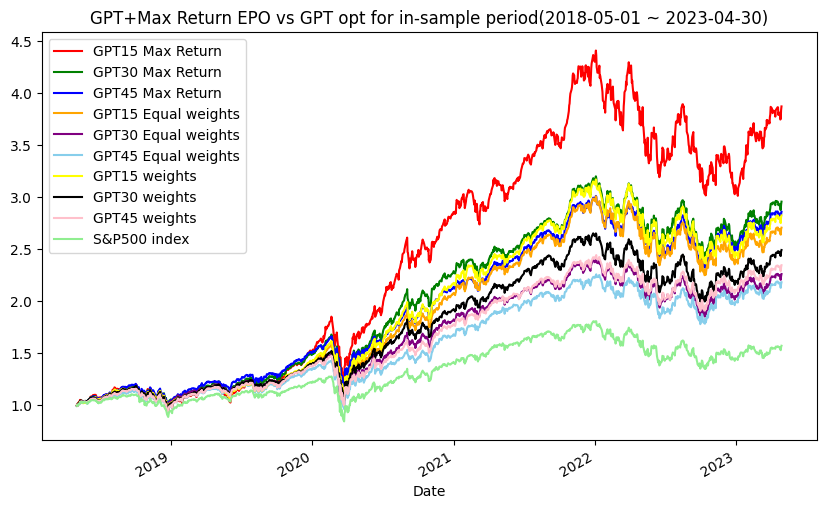

In [281]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Return EPO vs GPT opt for in-sample period(2018-05-01 ~ 2023-04-30)")

max_15.plot(label='GPT15 Max Return', color='red')
max_30.plot(label='GPT30 Max Return', color='green')
max_45.plot(label='GPT45 Max Return', color='blue')
cum_eq_15.plot(label='GPT15 Equal weights', color='orange')
cum_eq_30.plot(label='GPT30 Equal weights', color='purple')
cum_eq_45.plot(label='GPT45 Equal weights', color='skyblue')
gpt_15_in.plot(label='GPT15 weights', color='yellow')
gpt_30_in.plot(label='GPT30 weights', color='black')
gpt_45_in.plot(label='GPT45 weights', color='pink')
snpin.plot(label='S&P500 index', color='lightgreen')

plt.legend()
plt.show()

In [282]:
print(max_15.iloc[-1])  # 마지막 시점의 max_15 값
print(max_30.iloc[-1])  # 마지막 시점의 max_30 값
print(max_45.iloc[-1])  # 마지막 시점의 max_45 값

print('-----------------------------------------')

print(cum_eq_15.iloc[-1])  # 마지막 시점의 cum_eq_15 값
print(cum_eq_30.iloc[-1])  # 마지막 시점의 cum_eq_30 값
print(cum_eq_45.iloc[-1])  # 마지막 시점의 cum_eq_45 값

print('-----------------------------------------')

print(gpt_15_in.iloc[-1])  # 마지막 시점의 gpt_15_in 값
print(gpt_30_in.iloc[-1])  # 마지막 시점의 gpt_30_in 값
print(gpt_45_in.iloc[-1])  # 마지막 시점의 gpt_45_in 값

print('-----------------------------------------')

print(snpin.iloc[-1])  # 마지막 시점의 snpin 값

3.8719409661015023
2.956330392068083
2.858777690395785
-----------------------------------------
2.7061165235927196
2.260197455667387
2.181111816519948
-----------------------------------------
2.8237216659485793
2.4910817485574697
2.345144871791912
-----------------------------------------
1.570543884202969


### out-of-sample 누적 수익률 확인 2023-05-01 ~ 2023-10-10

In [283]:
# max return + epo
max_15 = max_ret_epo_cum_ret(stocks_15, max_ret_epo_15, '2023-05-01', '2023-10-31')
max_30 = max_ret_epo_cum_ret(stocks_30, max_ret_epo_30, '2023-05-01', '2023-10-31')
max_45 = max_ret_epo_cum_ret(stocks_45, max_ret_epo_45, '2023-05-01', '2023-10-31')

# equal weight
cum_eq_15 = cum_ret_gpt(gpt15_same, '2023-05-01', '2023-10-31')
cum_eq_30 = cum_ret_gpt(gpt30_same, '2023-05-01', '2023-10-31')
cum_eq_45 = cum_ret_gpt(gpt45_same, '2023-05-01', '2023-10-31')

100%|██████████| 15/15 [00:00<00:00, 747.22it/s]


포트폴리오의 MDD는: 12.0%
포트폴리오의 표준편차는: 0.0105
포트폴리오의 Sharpe Ratio는: -1.84


100%|██████████| 30/30 [00:00<00:00, 807.35it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.008
포트폴리오의 Sharpe Ratio는: -2.45


100%|██████████| 45/45 [00:00<00:00, 800.07it/s]


포트폴리오의 MDD는: 10.0%
포트폴리오의 표준편차는: 0.0075
포트폴리오의 Sharpe Ratio는: -2.63


100%|██████████| 45/45 [00:00<00:00, 813.90it/s]


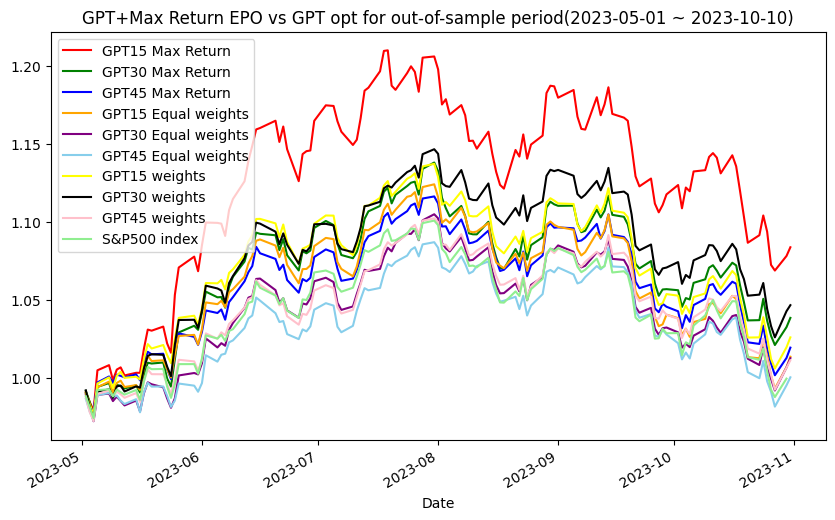

In [284]:
plt.figure(figsize=(10,6))
plt.title("GPT+Max Return EPO vs GPT opt for out-of-sample period(2023-05-01 ~ 2023-10-10)")

max_15.plot(label='GPT15 Max Return', color='red')
max_30.plot(label='GPT30 Max Return', color='green')
max_45.plot(label='GPT45 Max Return', color='blue')
cum_eq_15.plot(label='GPT15 Equal weights', color='orange')
cum_eq_30.plot(label='GPT30 Equal weights', color='purple')
cum_eq_45.plot(label='GPT45 Equal weights', color='skyblue')
gpt_15_out.plot(label='GPT15 weights', color='yellow')
gpt_30_out.plot(label='GPT30 weights', color='black')
gpt_45_out.plot(label='GPT45 weights', color='pink')
snpout.plot(label='S&P500 index', color='lightgreen')

plt.legend()
plt.show()

In [285]:
print(max_15.iloc[-1])  # 마지막 시점의 max_15 값
print(max_30.iloc[-1])  # 마지막 시점의 max_30 값
print(max_45.iloc[-1])  # 마지막 시점의 max_45 값

print('-----------------------------------------')

print(cum_eq_15.iloc[-1])  # 마지막 시점의 cum_eq_15 값
print(cum_eq_30.iloc[-1])  # 마지막 시점의 cum_eq_30 값
print(cum_eq_45.iloc[-1])  # 마지막 시점의 cum_eq_45 값

print('-----------------------------------------')

print(gpt_15_out.iloc[-1])  # 마지막 시점의 gpt_15_out 값
print(gpt_30_out.iloc[-1])  # 마지막 시점의 gpt_30_out 값
print(gpt_45_out.iloc[-1])  # 마지막 시점의 gpt_45_out 값

print('-----------------------------------------')

print(snpout.iloc[-1])  # 마지막 시점의 snpout 값

1.083947428431087
1.0386675898173885
1.0195945127987558
-----------------------------------------
1.0137846445574363
1.0128294199046595
1.0005676210191787
-----------------------------------------
1.0261699613903503
1.0468227153541398
1.011530650327948
-----------------------------------------
0.9997480024714747
